In [2]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
# تحميل البيانات
df = pd.read_csv("Groceries_dataset.csv")  

In [4]:
df

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk
...,...,...,...
38760,4471,08-10-2014,sliced cheese
38761,2022,23-02-2014,candy
38762,1097,16-04-2014,cake bar
38763,1510,03-12-2014,fruit/vegetable juice


In [5]:
# تحويل البيانات إلى قائمة من القوائم
transactions = df.groupby('Member_number')['itemDescription'].apply(list)

In [6]:
# تحويل البيانات إلى مصفوفة (One-Hot Encoding)
from mlxtend.preprocessing import TransactionEncoder

In [7]:
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

In [8]:
# استخراج المجموعات المتكررة باستخدام Apriori
frequent_itemsets = apriori(df_encoded, min_support=0.02, use_colnames=True)

In [9]:
# association_rules استخراج 
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

In [10]:
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

               antecedents                       consequents   support  \
0               (UHT-milk)                   (bottled water)  0.021293   
1          (bottled water)                        (UHT-milk)  0.021293   
2               (UHT-milk)                (other vegetables)  0.038994   
3       (other vegetables)                        (UHT-milk)  0.038994   
4               (UHT-milk)                      (rolls/buns)  0.031042   
...                    ...                               ...       ...   
2951  (whole milk, yogurt)                (rolls/buns, soda)  0.024628   
2952          (rolls/buns)        (soda, whole milk, yogurt)  0.024628   
2953                (soda)  (rolls/buns, whole milk, yogurt)  0.024628   
2954          (whole milk)        (rolls/buns, soda, yogurt)  0.024628   
2955              (yogurt)    (rolls/buns, soda, whole milk)  0.024628   

      confidence      lift  
0       0.271242  1.269268  
1       0.099640  1.269268  
2       0.496732  1.3189

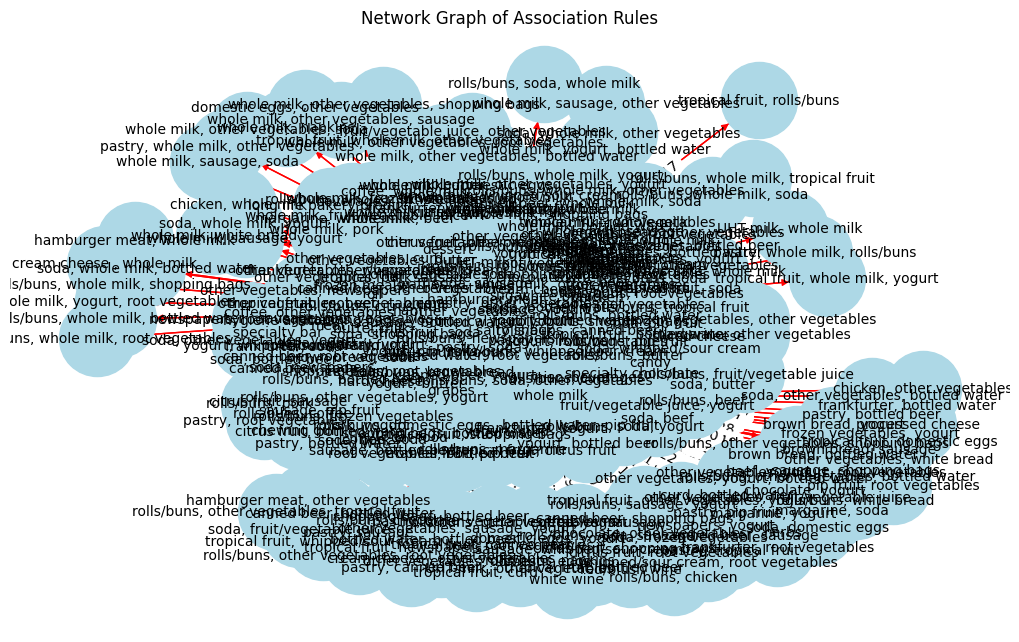

In [11]:
# إنشاء الرسم البياني للعلاقات بين المنتجات
G = nx.DiGraph()

for _, row in rules.iterrows():
    G.add_edge(", ".join(row['antecedents']), ", ".join(row['consequents']), weight=row['lift'])

plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G, seed=42)
edges = G.edges(data=True)

nx.draw(G, pos, with_labels=True, node_size=3000, node_color="lightblue", edge_color="red", font_size=10)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f"{d['weight']:.2f}" for u, v, d in edges})

plt.title("Network Graph of Association Rules")
plt.show()

In [12]:
print("edge numbers:", len(G.edges()))
print("nodes numbers:", len(G.nodes()))
#print("edges:", list(G.edges(data=True)))

edge numbers: 2956
nodes numbers: 303


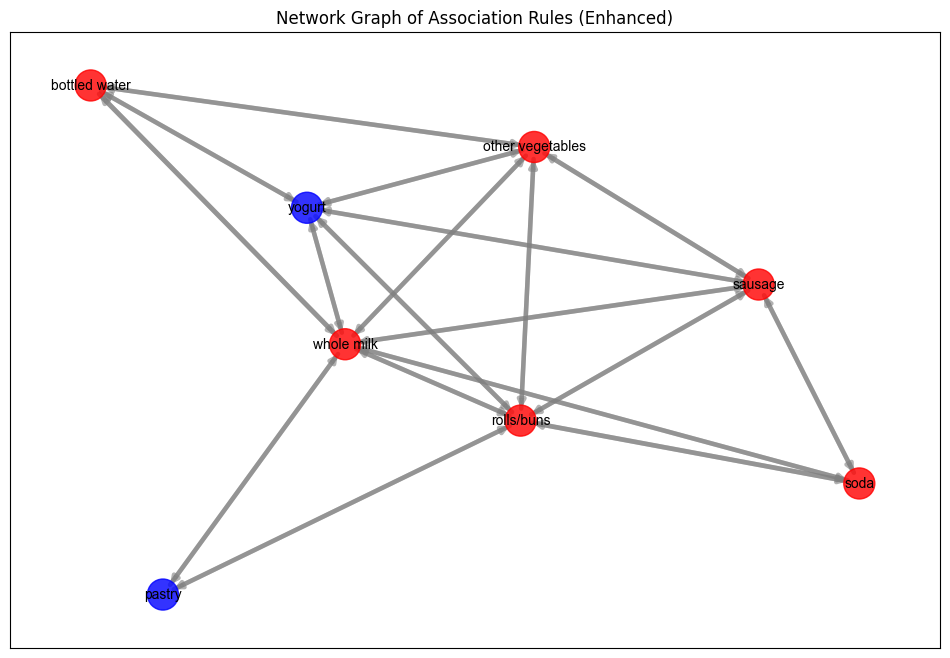

In [14]:
import networkx as nx
import matplotlib.pyplot as plt

# اختيار أفضل القواعد بناءً على lift
filtered_rules = rules[(rules['lift'] > 1.0) & (rules['support'] > 0.01)]
top_rules = filtered_rules.nlargest(30, 'lift')

# إنشاء المخطط الشبكي
G = nx.DiGraph()

# إضافة  (العناصر)
for _, row in rules.iterrows():
    for item in row['antecedents']:
        G.add_node(item, color='blue', size=500)
    for item in row['consequents']:
        G.add_node(item, color='red', size=500)

# إضافة edges (العلاقات بين العناصر)
for _, row in top_rules.iterrows():
    for ante in row['antecedents']:
        for conseq in row['consequents']:
            G.add_edge(ante, conseq, weight=row['lift'])

# رسم المخطط
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.5)  # تحسين توزيع العقد
# رسم nodes
node_colors = ['blue' if G.nodes[node]['color'] == 'blue' else 'red' for node in G.nodes()]
node_sizes = [G.nodes[node]['size'] for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.8)

# رسم edges
edges = G.edges(data=True)
weights = [edge[2]['weight'] * 2 for edge in edges]  # مضاعفة سماكة الحواف بناءً على قوة العلاقة
nx.draw_networkx_edges(G, pos, edgelist=edges, width=weights, alpha=0.6, edge_color='gray')

# رسم التسميات
nx.draw_networkx_labels(G, pos, font_size=10, font_family="Arial")

plt.title("Network Graph of Association Rules (Enhanced)")
plt.show()
